## All TCP connections made during the crawls
- 

In [1]:
import numpy as np
import pandas as pd
from log_analysis import (get_domain_by_ip, load_timestamps_from_crawl_data,
                          get_distinct_tcp_conns, get_crawl_data_path,
                          load_dns_data, get_crawl_status, get_epoch)

from os.path import isdir, join
from datetime import datetime
from glob import glob
from tabulate import tabulate
import seaborn as sns

ROKU_NO_MITM_CRAWL = 'roku-data-20190501-031836'
crawl_data_dir_roku = get_crawl_data_path(ROKU_NO_MITM_CRAWL)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
roku_crawl_results = get_crawl_status(crawl_data_dir_roku)
# amazon_crawl_results = get_crawl_status(crawl_data_dir_amazon)
crawl_results = roku_crawl_results.copy()
# crawl_results.update(amazon_crawl_results)

In [3]:
roku_tcp = get_distinct_tcp_conns(crawl_data_dir_roku)
# amazon_tcp = get_distinct_tcp_conns(crawl_data_dir_amazon)

Loading distinct TCP connections from /media/gacar/Data/iot-house/crawl-data/roku-data-20190501-031836/post-process 


In [4]:
len(roku_tcp)

8447

In [19]:
roku_tcp.disconnect_blocked.value_counts()

False    7128
True     1319
Name: disconnect_blocked, dtype: int64

In [20]:
roku_tcp.drop_duplicates("host_by_dns").disconnect_blocked.value_counts()

False    338
True     114
Name: disconnect_blocked, dtype: int64

In [6]:
roku_tcp.head(3)

,tcp_stream,frame_time_epoch,ip_src,ip_dst,tcp_dstport,channel_id,mitm_attempt,host_by_dns,domain_by_dns,disconnect_blocked,timestamp,channel_name,rank,category,playback
0,7,1.556712e+09,10.42.0.119,23.22.241.63,443,13992,0,api.roku.com,roku.com,False,2019-05-01 07:58:52,Healthy Recipes by iFood.tv,1161,Food,True
1,8,1.556712e+09,10.42.0.119,54.192.49.6,443,13992,0,image.roku.com,roku.com,False,2019-05-01 07:58:52,Healthy Recipes by iFood.tv,1161,Food,True
2,11,1.556712e+09,10.42.0.119,34.193.43.251,443,13992,0,api.roku.com,roku.com,False,2019-05-01 07:58:54,Healthy Recipes by iFood.tv,1161,Food,True


In [7]:
#amazon_tcp.head(3)

## Unmatched IP addresses
- the IP addresses we cannot find the domain for

In [8]:
len(roku_tcp[roku_tcp.host_by_dns==""])

196

In [9]:
roku_tcp[roku_tcp.host_by_dns==""]["ip_dst"].value_counts()

8.8.8.8           186
34.210.236.142      5
54.201.163.62       3
34.218.209.122      1
54.235.17.159       1
Name: ip_dst, dtype: int64

In [10]:
roku_tcp.host_by_dns.nunique()

452

In [11]:
roku_tcp.domain_by_dns.nunique()

243

In [12]:
# amazon_tcp.host_by_dns.nunique()

In [14]:
sns.set(rc={'figure.figsize':(16, 20)}, style="darkgrid")
sns.set(font_scale = 2)

In [31]:
df_n_blocked_domains_by_channel = roku_tcp[roku_tcp.disconnect_blocked].drop_duplicates(subset=["channel_name", "domain_by_dns"]).\
    groupby(["channel_id", "category", "channel_name", "rank", "playback"]).size().reset_index(name="# adblocked domains").\
    sort_values(by=['# adblocked domains'], ascending=False)
df_n_blocked_domains_by_channel.head(10)

,channel_id,category,channel_name,rank,playback,# adblocked domains
88,90598,Special Interest,Relax My Dog - TV and Music,369,True,16
52,36732,Special Interest,Models In Motion,355,True,14
8,121375,Special Interest,Sexy Shorts,224,True,10
78,71845,News & Weather,NewsON,33,True,9
66,53725,Sports,NBC Sports,38,True,8
61,46450,Food,CopyKat Recipes,1186,True,8
65,52838,kids-family,Nickelodeon,57,True,7
13,150523,Special Interest,Grindhouse Connection Plus,262,False,6
21,172665,News & Weather,Haystack TV Local & World News,75,True,6
20,17112,Sports,CBS Sports Stream & Watch Live,104,True,6


In [28]:
df_n_domains_by_channel = roku_tcp.drop_duplicates(subset=["channel_name", "domain_by_dns"]).\
    groupby(["channel_id", "category", "channel_name", "rank", "playback"]).size().reset_index(name="# domain_by_dns").\
    sort_values(by=['# domain_by_dns'], ascending=False)
df_n_domains_by_channel.head(10)

,channel_id,category,channel_name,rank,playback,# domain_by_dns
88,90598,Special Interest,Relax My Dog - TV and Music,369,True,26
52,36732,Special Interest,Models In Motion,355,True,24
73,65978,News & Weather,CNNgo,60,True,17
78,71845,News & Weather,NewsON,33,True,16
20,17112,Sports,CBS Sports Stream & Watch Live,104,True,15
8,121375,Special Interest,Sexy Shorts,224,True,15
61,46450,Food,CopyKat Recipes,1186,True,15
66,53725,Sports,NBC Sports,38,True,14
65,52838,kids-family,Nickelodeon,57,True,14
13,150523,Special Interest,Grindhouse Connection Plus,262,False,13


In [29]:
# exclude chanels without playback
# detect trackers

In [30]:
print(tabulate(df_n_domains_by_channel.head(10), tablefmt="pipe", headers="keys"))

|    |   channel_id | category         | channel_name                   |   rank | playback   |   # domain_by_dns |
|---:|-------------:|:-----------------|:-------------------------------|-------:|:-----------|------------------:|
| 88 |        90598 | Special Interest | Relax My Dog - TV and Music    |    369 | True       |                26 |
| 52 |        36732 | Special Interest | Models In Motion               |    355 | True       |                24 |
| 73 |        65978 | News & Weather   | CNNgo                          |     60 | True       |                17 |
| 78 |        71845 | News & Weather   | NewsON                         |     33 | True       |                16 |
| 20 |        17112 | Sports           | CBS Sports Stream & Watch Live |    104 | True       |                15 |
|  8 |       121375 | Special Interest | Sexy Shorts                    |    224 | True       |                15 |
| 61 |        46450 | Food             | CopyKat Recipes                

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


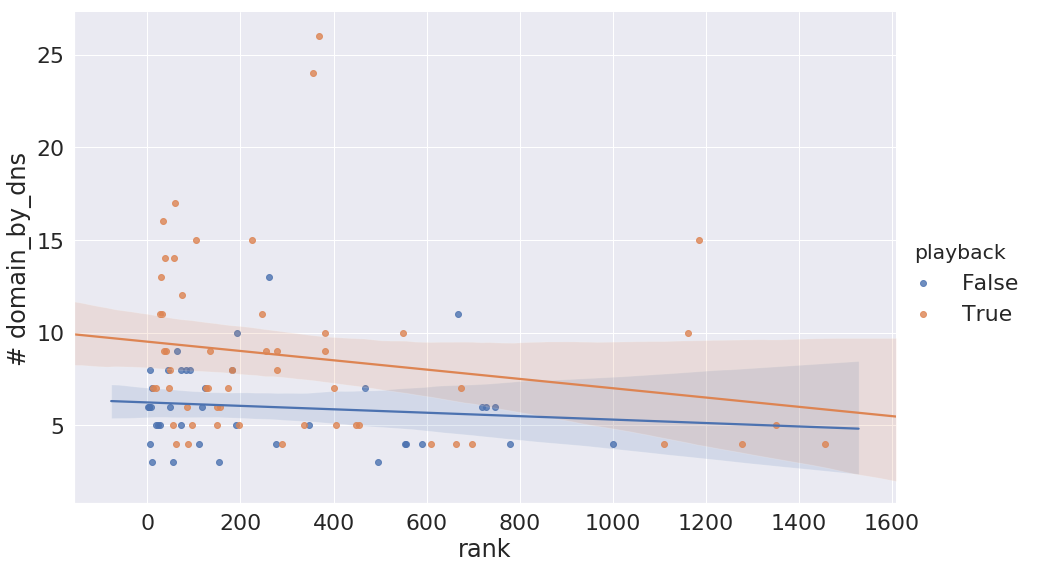

In [18]:
sns.lmplot(x='rank', y='# domain_by_dns', data=df_n_domains_by_channel,
                hue='playback', legend_out=True, height=8, aspect=1.6)


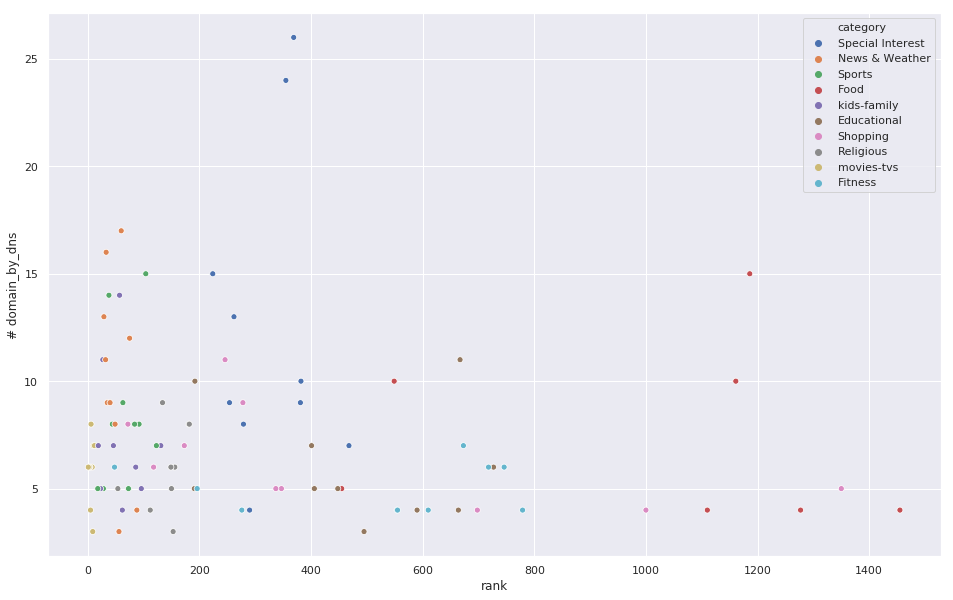

In [51]:
sns.set(rc={'figure.figsize':(16, 10)}, style="darkgrid")
sns.set(font_scale = 1)
ax = sns.scatterplot(x='rank', y='# domain_by_dns', data=df_n_domains_by_channel,
                hue='category')

#ax.set(xscale="log")

#plt.show()

In [13]:
roku_tcp[~roku_tcp.host_by_dns.str.contains("roku.com") & (roku_tcp.host_by_dns != '')].drop_duplicates(subset=["channel_id", "host_by_dns"]).\
    groupby(["host_by_dns"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,host_by_dns,# channels
290,pubads.g.doubleclick.net,92
411,www.google-analytics.com,17
158,dpm.demdex.net,13
359,static.ifood.tv,12
221,log.ifood.tv,12
325,s3.amazonaws.com,11
332,search.spotxchange.com,9
75,b.scorecardresearch.com,8
327,sb.scorecardresearch.com,7
371,tag.1rx.io,7


In [33]:
roku_tcp[roku_tcp.disconnect_blocked].drop_duplicates(subset=["channel_id", "domain_by_dns"]).\
    groupby(["domain_by_dns"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,domain_by_dns,# channels
29,doubleclick.net,94
36,google-analytics.com,22
27,demdex.net,15
54,scorecardresearch.com,14
58,spotxchange.com,9
49,omtrdc.net,8
61,tremorhub.com,8
63,vimeocdn.com,7
0,1rx.io,7
4,adobe.com,7


In [20]:
roku_tcp[~roku_tcp.domain_by_dns.str.contains("roku.com", na=False) & (roku_tcp.domain_by_dns != '')].drop_duplicates(subset=["channel_id", "domain_by_dns"]).\
    groupby(["domain_by_dns"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,domain_by_dns,# channels
69,doubleclick.net,94
96,google-analytics.com,22
65,demdex.net,15
17,akamaihd.net,15
189,scorecardresearch.com,14
109,ifood.tv,12
188,s3.amazonaws.com,11
198,spotxchange.com,9
213,tremorhub.com,8
167,omtrdc.net,8


In [14]:
roku_tcp[~roku_tcp.host_by_dns.str.contains("roku.com") &
         (roku_tcp["tcp_dstport"] == 80) &
         (roku_tcp.host_by_dns != 'unknown')].drop_duplicates(subset=["channel_name", "host_by_dns"]).\
    groupby(["host_by_dns"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,host_by_dns,# channels
146,static.ifood.tv,12
59,dpm.demdex.net,10
29,b.scorecardresearch.com,8
174,www.google-analytics.com,8
154,tag.1rx.io,7
4,PD13201-gc48b.ads.tremorhub.com,6
124,pubads.g.doubleclick.net,6
34,boot.irchan.com,6
134,sb.scorecardresearch.com,5
64,events.tremorhub.com,5


In [21]:
roku_tcp[~roku_tcp.domain_by_dns.str.contains("roku.com", na=False) &
         (roku_tcp["tcp_dstport"] == 80) &
         (roku_tcp.domain_by_dns != 'unknown')].drop_duplicates(subset=["channel_name", "domain_by_dns"]).\
    groupby(["domain_by_dns"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,domain_by_dns,# channels
95,scorecardresearch.com,13
52,ifood.tv,12
32,demdex.net,11
34,doubleclick.net,10
47,google-analytics.com,8
9,akamaihd.net,7
106,tremorhub.com,7
0,1rx.io,7
56,irchan.com,6
86,omtrdc.net,6


In [29]:
amazon_tcp[
    ~amazon_tcp.hostname.str.contains("amazon.com") &
           (amazon_tcp.hostname != 'unknown')].drop_duplicates(subset=["channel_name", "hostname"]).\
    groupby(["hostname"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(20)

,hostname,# channels
9,aax-us-east.amazon-adsystem.com,99
122,graph.facebook.com,95
328,z.moatads.com,93
247,sb.scorecardresearch.com,93
150,mobile-collector.newrelic.com,93
64,can.cbs.com,92
106,dpm.demdex.net,92
242,s.amazon-adsystem.com,86
292,udm.scorecardresearch.com,75
26,andr-785f3ec7eb-cbc62794911ff31b-c55635c491a5a...,72


In [38]:
amazon_tcp[amazon_tcp.hostname.str.contains("facebook.com")].\
    drop_duplicates(['channel_name', 'hostname']).sort_values("frame_time_epoch")

,tcp_stream,frame_time_epoch,ip_src,ip_dst,tcp_dstport,channel_name,mitm_attempt,hostname,timestamp
0,0,1.555348e+09,10.42.0.198,31.13.80.8,443,com.gtv.goodparent,0,graph.facebook.com,2019-04-15 13:11:03
54,65,1.555350e+09,10.42.0.198,31.13.80.8,443,com.amazon.rialto.cordova.webapp.webappc26b1d7...,0,graph.facebook.com,2019-04-15 13:44:13
65,77,1.555352e+09,10.42.0.198,31.13.80.8,443,com.ventuno.tv.firetv.frames21,0,graph.facebook.com,2019-04-15 14:17:59
90,111,1.555354e+09,10.42.0.198,31.13.80.8,443,com.netflix.ninja,0,graph.facebook.com,2019-04-15 14:44:14
0,1,1.555354e+09,10.42.0.198,31.13.80.8,443,com.viewlift.peopleawesome,0,graph.facebook.com,2019-04-15 14:46:45
23,41,1.555356e+09,10.42.0.198,31.13.80.8,443,com.elevatetv.tv.platform,0,graph.facebook.com,2019-04-15 15:17:26
35,48,1.555357e+09,10.42.0.198,31.13.80.8,443,com.tulix.ginikousafiretv,0,graph.facebook.com,2019-04-15 15:44:16
140,145,1.555359e+09,10.42.0.198,31.13.80.8,443,com.antena3.atresplayer.tv,0,graph.facebook.com,2019-04-15 16:17:26
60,71,1.555361e+09,10.42.0.198,31.13.80.8,443,com.nortextv.tv.platform,0,graph.facebook.com,2019-04-15 16:44:19
0,0,1.555362e+09,10.42.0.198,31.13.80.8,443,com.gtv.safenetwork,0,graph.facebook.com,2019-04-15 16:51:47


In [34]:
amazon_tcp[~amazon_tcp.hostname.str.contains("amazon.com") &
         (amazon_tcp["tcp_dstport"] == 80) &
         (amazon_tcp.hostname != 'unknown')].drop_duplicates(subset=["channel_name", "hostname"]).\
    groupby(["hostname"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,hostname,# channels
2,aax-us-east.amazon-adsystem.com,99
54,spectrum.s3.amazonaws.com,68
27,globalstreamingserver.com,14
5,amazon-web-app-whitelist.s3.amazonaws.com,6
59,static1.dmcdn.net,5
6,amazon.streamingtelevisioninc.com,5
49,res.cloudinary.com,4
26,equality.bigstar.tv,3
0,8s3.lvlt.dash.us.aiv-cdn.net,3
50,s.amazon-adsystem.com,3


In [36]:
amazon_tcp[~amazon_tcp.hostname.str.contains("amazon.com") &
           (amazon_tcp["tcp_dstport"] == 80) &
           (amazon_tcp.hostname != 'unknown')].drop_duplicates(subset=["channel_name", "hostname"]).\
    groupby(["hostname"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,hostname,# channels
2,aax-us-east.amazon-adsystem.com,99
54,spectrum.s3.amazonaws.com,68
27,globalstreamingserver.com,14
5,amazon-web-app-whitelist.s3.amazonaws.com,6
59,static1.dmcdn.net,5
6,amazon.streamingtelevisioninc.com,5
49,res.cloudinary.com,4
26,equality.bigstar.tv,3
0,8s3.lvlt.dash.us.aiv-cdn.net,3
50,s.amazon-adsystem.com,3


In [37]:
roku_tcp[roku_tcp.hostname == 'pubads.g.doubleclick.net']

,tcp_stream,frame_time_epoch,ip_src,ip_dst,tcp_dstport,channel_name,mitm_attempt,hostname,timestamp
13,30,1.555178e+09,10.42.0.119,172.217.12.194,443,56317,0,pubads.g.doubleclick.net,2019-04-13 13:52:25
14,33,1.555178e+09,10.42.0.119,172.217.12.194,443,56317,0,pubads.g.doubleclick.net,2019-04-13 13:52:25
238,395,1.555178e+09,10.42.0.119,172.217.12.194,443,56317,0,pubads.g.doubleclick.net,2019-04-13 13:56:04
244,401,1.555178e+09,10.42.0.119,172.217.12.194,443,56317,0,pubads.g.doubleclick.net,2019-04-13 13:56:06
258,415,1.555178e+09,10.42.0.119,172.217.12.194,443,56317,0,pubads.g.doubleclick.net,2019-04-13 13:56:10
293,477,1.555178e+09,10.42.0.119,172.217.12.194,443,56317,0,pubads.g.doubleclick.net,2019-04-13 13:57:20
388,626,1.555178e+09,10.42.0.119,172.217.12.194,443,56317,0,pubads.g.doubleclick.net,2019-04-13 13:59:57
446,707,1.555178e+09,10.42.0.119,172.217.12.194,443,56317,0,pubads.g.doubleclick.net,2019-04-13 14:01:11
460,721,1.555178e+09,10.42.0.119,172.217.12.194,443,56317,0,pubads.g.doubleclick.net,2019-04-13 14:01:17
463,724,1.555178e+09,10.42.0.119,172.217.12.194,443,56317,0,pubads.g.doubleclick.net,2019-04-13 14:01:17
